In [243]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [244]:
df = pd.read_csv('auto-mpg.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


### Verificar Valores Nulos

In [246]:
# Verificar valores nulos
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [247]:
# Contar valores '?' en horsepower
print("\nNúmero de valores '?' en horsepower:", (df['horsepower'] == '?').sum())


Número de valores '?' en horsepower: 6


### Remmplazar '?' con NaN y Convertir a Numerico

In [248]:
import numpy as np
# Reemplazar '?' por NaN y convertir a numérico
df['horsepower'] = df['horsepower'].replace('?', np.nan)
df['horsepower'] = pd.to_numeric(df['horsepower'])

In [249]:
# Verificar valores nulos después de la conversión
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [250]:
# Estadísticas descriptivas de horsepower
print("\nEstadísticas de horsepower antes de la imputación:")
df['horsepower'].describe()


Estadísticas de horsepower antes de la imputación:


count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: horsepower, dtype: float64

In [251]:
from sklearn.impute import SimpleImputer

# Imputar valores nulos en horsepower con la mediana
imputer = SimpleImputer(strategy='median')
df['horsepower'] = imputer.fit_transform(df[['horsepower']])

# Verificar valores nulos después de la imputación
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

Técnica elegida: SimpleImputer con mediana, porque:

La mediana (93.5) es robusta frente a valores atípicos (máximo 230, sesgo moderado).
Solo 6 valores faltantes (1.5%) justifican una imputación simple.
La mediana es adecuada para la distribución sesgada de horsepower. Se resolvieron los 6 valores nulos originales.

In [252]:
# Generar valores nulos en weight (5% de las filas)
np.random.seed(42)  # Para reproducibilidad
mask = np.random.choice([True, False], size=df.shape[0], p=[0.05, 0.95])
df.loc[mask, 'weight'] = np.nan

# Verificar valores nulos después de generarlos
df.isnull().sum()

mpg              0
cylinders        0
displacement     0
horsepower       0
weight          26
acceleration     0
model year       0
origin           0
car name         0
dtype: int64

In [253]:
# Estadísticas descriptivas de weight
print("\nEstadísticas de weight antes de la imputación:")
df['weight'].describe()


Estadísticas de weight antes de la imputación:


count     372.000000
mean     2982.123656
std       846.304174
min      1613.000000
25%      2233.000000
50%      2831.500000
75%      3614.750000
max      5140.000000
Name: weight, dtype: float64

In [254]:
# Imputar valores nulos en weight
imputer = SimpleImputer(strategy='median')
df['weight'] = imputer.fit_transform(df[['weight']])

# Verificar valores nulos
print("\nValores nulos después de imputar weight:")
df.isnull().sum()


Valores nulos después de imputar weight:


mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [255]:
# Tipos de datos
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

## 2. Conversion de Atributos con OneHotEncoder

In [256]:
# Número de valores únicos en car name
print("\nNúmero de valores únicos en car name:", df['car name'].nunique())

# Extraer la marca
df['brand'] = df['car name'].apply(lambda x: x.split()[0])

# Verificar marcas
print("\nNúmero de marcas únicas:", df['brand'].nunique())
print("\nFrecuencia de las 5 marcas más comunes:")
df['brand'].value_counts().head()


Número de valores únicos en car name: 305

Número de marcas únicas: 37

Frecuencia de las 5 marcas más comunes:


brand
ford         51
chevrolet    43
plymouth     31
amc          28
dodge        28
Name: count, dtype: int64

In [257]:
from sklearn.preprocessing import OneHotEncoder

# Codificar brand
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
brand_encoded = encoder.fit_transform(df[['brand']])
brand_encoded_df = pd.DataFrame(brand_encoded, columns=encoder.get_feature_names_out(['brand']))

# Concatenar y eliminar columnas
df = pd.concat([df, brand_encoded_df], axis=1)
df = df.drop(['brand', 'car name'], axis=1)

# Mostrar primeras filas
print("\nPrimeras filas después de codificar brand:")
df.head()


Primeras filas después de codificar brand:


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,brand_amc,brand_audi,...,brand_renault,brand_saab,brand_subaru,brand_toyota,brand_toyouta,brand_triumph,brand_vokswagen,brand_volkswagen,brand_volvo,brand_vw
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [258]:
# Valores únicos en origin
print("\nValores únicos en origin:", df['origin'].unique())


Valores únicos en origin: [1 3 2]


## 3. Esacalado de Atributos con StandardScaler

In [259]:
num_cols = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
print("\nEstadísticas descriptivas de las columnas numéricas:")
df[num_cols].describe()

print("\nSesgo (skewness):")
df[num_cols].skew()


Estadísticas descriptivas de las columnas numéricas:

Sesgo (skewness):


mpg             0.457066
cylinders       0.526922
displacement    0.719645
horsepower      1.106224
weight          0.567646
acceleration    0.278777
model year      0.011535
origin          0.923776
dtype: float64

In [260]:
from sklearn.preprocessing import StandardScaler

# Escalar columnas numéricas (excepto mpg y brand_*)
num_cols_to_scale = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
scaler = StandardScaler()
df[num_cols_to_scale] = scaler.fit_transform(df[num_cols_to_scale])

# Mostrar estadísticas
print("\nEstadísticas después de StandardScaler:")
df[num_cols_to_scale].describe()


Estadísticas después de StandardScaler:


,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02
mean,-3.570567e-17,-1.785283e-17,-7.141133e-17,-7.141133e-17,-2.677925e-16,-1.642461e-15,-5.355850e-17
std,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00
min,-1.444949e+00,-1.204411e+00,-1.527300e+00,-1.661836e+00,-2.747814e+00,-1.627426e+00,-7.151448e-01
25%,-8.563206e-01,-8.563178e-01,-7.414364e-01,-8.647126e-01,-6.328794e-01,-8.150739e-01,-7.151448e-01
50%,-8.563206e-01,-4.314040e-01,-2.830161e-01,-1.721199e-01,-2.472221e-02,-2.721449e-03,-7.151448e-01
75%,1.498191e+00,6.584879e-01,5.421404e-01,6.742125e-01,5.834349e-01,8.096310e-01,5.332220e-01
max,1.498191e+00,2.511784e+00,3.292662e+00,2.650211e+00,3.351912e+00,1.621983e+00,1.781589e+00


 ## 4. Seleccion de Atributos

In [261]:
# Separar X e y
X = df.drop('mpg', axis=1)
y = df['mpg']
print("\nDimensiones de X:", X.shape)  # (398, 41)


Dimensiones de X: (398, 44)


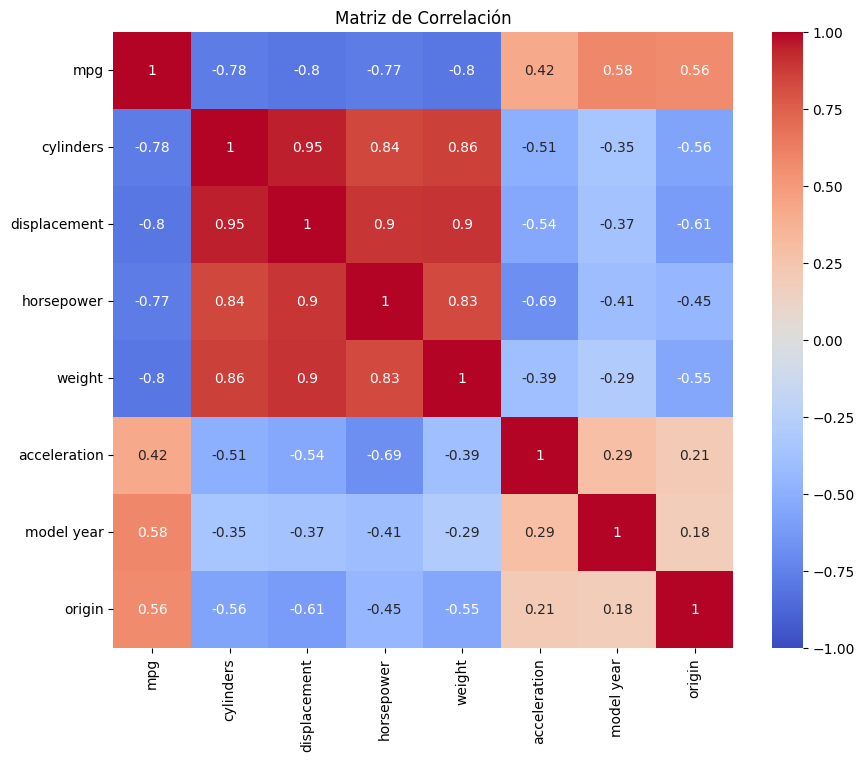


Correlaciones con mpg:
mpg             1.000000
model year      0.579267
origin          0.563450
acceleration    0.420289
horsepower     -0.773453
cylinders      -0.775396
weight         -0.796896
displacement   -0.804203
Name: mpg, dtype: float64


In [262]:
# Columnas numéricas + mpg
num_cols = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
corr_matrix = df[num_cols].corr()

# Visualizar matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlación')
plt.show()

# Correlaciones con mpg
print("\nCorrelaciones con mpg:")
print(corr_matrix['mpg'].sort_values(ascending=False))

In [263]:
# Modelo base
model = LinearRegression()

# RFE para 6 atributos
rfe = RFE(estimator=model, n_features_to_select=6)
rfe.fit(X, y)

# Ranking y selección
rfe_ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe.ranking_, 'Selected': rfe.support_})
print("\nRanking de características (RFE, 6 atributos):")
print(rfe_ranking.sort_values(by='Ranking').head(10))

# Características seleccionadas
selected_features_rfe = X.columns[rfe.support_].tolist()
print("\nAtributos seleccionados por RFE:", selected_features_rfe)


Ranking de características (RFE, 6 atributos):
           Feature  Ranking  Selected
3           weight        1      True
28    brand_nissan        1      True
22     brand_honda        1      True
17    brand_datsun        1      True
43        brand_vw        1      True
39   brand_triumph        1      True
34   brand_renault        2     False
5       model year        3     False
11  brand_cadillac        4     False
23     brand_maxda        5     False

Atributos seleccionados por RFE: ['weight', 'brand_datsun', 'brand_honda', 'brand_nissan', 'brand_triumph', 'brand_vw']


In [264]:
# Árbol de decisión
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X, y)

# Importancia de características
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': tree.feature_importances_})
print("\nImportancia de características (Árbol de Decisión):")
print(feature_importance.sort_values(by='Importance', ascending=False).head(10))

# Top 6
top_features_tree = feature_importance.nlargest(6, 'Importance')['Feature'].tolist()
print("\nAtributos seleccionados por Árbol de Decisión:", top_features_tree)


Importancia de características (Árbol de Decisión):
            Feature  Importance
1      displacement    0.598853
2        horsepower    0.170475
5        model year    0.109444
3            weight    0.073291
4      acceleration    0.021412
43         brand_vw    0.007851
6            origin    0.006482
0         cylinders    0.003536
24      brand_mazda    0.002487
14  brand_chevrolet    0.000935

Atributos seleccionados por Árbol de Decisión: ['displacement', 'horsepower', 'model year', 'weight', 'acceleration', 'brand_vw']


In [265]:
# Seleccionar atributos
selected_features = ['weight', 'horsepower', 'model year', 'acceleration', 'brand_vw']
X_selected = X[selected_features]
print("\nDimensiones de X_selected:", X_selected.shape)  # (398, 5)


Dimensiones de X_selected: (398, 5)


# Modelado

In [266]:
# Asumimos X_selected y y ya definidos
print("Dimensiones de X_selected:", X_selected.shape)  # (398, 5)
print("Primeras filas de X_selected:\n", X_selected.head())
print("Primeras filas de y:\n", y.head())

Dimensiones de X_selected: (398, 5)
Primeras filas de X_selected:
      weight  horsepower  model year  acceleration  brand_vw
0  0.650067    0.673118   -1.627426     -1.295498       0.0
1  0.881135    1.589958   -1.627426     -1.477038       0.0
2  0.566931    1.197027   -1.627426     -1.658577       0.0
3  0.563263    1.197027   -1.627426     -1.295498       0.0
4  0.582825    0.935072   -1.627426     -1.840117       0.0
Primeras filas de y:
 0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64


In [267]:
# Configurar red neuronal
nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', 
                        max_iter=1000, random_state=42, early_stopping=True, validation_fraction=0.1)

# K-Fold Cross-Validation (k=5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# R²
nn_r2_scores = cross_val_score(nn_model, X_selected, y, cv=kf, scoring='r2')
nn_r2_mean = nn_r2_scores.mean()
nn_r2_std = nn_r2_scores.std()
nn_r2_var = nn_r2_std ** 2

# RMSE
nn_rmse_scores = np.sqrt(-cross_val_score(nn_model, X_selected, y, cv=kf, scoring='neg_mean_squared_error'))
nn_rmse_mean = nn_rmse_scores.mean()
nn_rmse_std = nn_rmse_scores.std()
nn_rmse_var = nn_rmse_std ** 2

print("\nRed Neuronal (MLPRegressor) - Resultados de Validación Cruzada (k=5):")
print(f"R² - Media: {nn_r2_mean:.4f}, Desviación Estándar: {nn_r2_std:.4f}, Varianza: {nn_r2_var:.4f}")
print(f"RMSE - Media: {nn_rmse_mean:.4f}, Desviación Estándar: {nn_rmse_std:.4f}, Varianza: {nn_rmse_var:.4f}")


Red Neuronal (MLPRegressor) - Resultados de Validación Cruzada (k=5):
R² - Media: 0.8494, Desviación Estándar: 0.0200, Varianza: 0.0004
RMSE - Media: 3.0154, Desviación Estándar: 0.3185, Varianza: 0.1014


In [268]:
# Configurar Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# R²
rf_r2_scores = cross_val_score(rf_model, X_selected, y, cv=kf, scoring='r2')
rf_r2_mean = rf_r2_scores.mean()
rf_r2_std = rf_r2_scores.std()
rf_r2_var = rf_r2_std ** 2

# RMSE
rf_rmse_scores = np.sqrt(-cross_val_score(rf_model, X_selected, y, cv=kf, scoring='neg_mean_squared_error'))
rf_rmse_mean = rf_rmse_scores.mean()
rf_rmse_std = rf_rmse_scores.std()
rf_rmse_var = rf_rmse_std ** 2

print("\nRandom Forest Regressor - Resultados de Validación Cruzada (k=5):")
print(f"R² - Media: {rf_r2_mean:.4f}, Desviación Estándar: {rf_r2_std:.4f}, Varianza: {rf_r2_var:.4f}")
print(f"RMSE - Media: {rf_rmse_mean:.4f}, Desviación Estándar: {rf_rmse_std:.4f}, Varianza: {rf_rmse_var:.4f}")


Random Forest Regressor - Resultados de Validación Cruzada (k=5):
R² - Media: 0.8579, Desviación Estándar: 0.0347, Varianza: 0.0012
RMSE - Media: 2.9167, Desviación Estándar: 0.4258, Varianza: 0.1813


In [269]:
from sklearn.model_selection import train_test_split

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [270]:
# Entrenar Red Neuronal
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict(X_test)

# Entrenar Random Forest
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Métricas en conjunto de prueba
nn_r2_test = r2_score(y_test, y_pred_nn)
nn_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_nn)) 
rf_r2_test = r2_score(y_test, y_pred_rf)
rf_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_rf))  

print("\nMétricas en conjunto de prueba:")
print(f"Red Neuronal - R²: {nn_r2_test:.4f}, RMSE: {nn_rmse_test:.4f}")
print(f"Random Forest - R²: {rf_r2_test:.4f}, RMSE: {rf_rmse_test:.4f}")


Métricas en conjunto de prueba:
Red Neuronal - R²: 0.8799, RMSE: 2.5416
Random Forest - R²: 0.8967, RMSE: 2.3569


In [273]:
# === Porcentaje dentro de ±2 mpg (Conjunto de Prueba) ===
nn_within_2mpg = np.mean(np.abs(y_test - y_pred_nn) <= 2.0) * 100
rf_within_2mpg = np.mean(np.abs(y_test - y_pred_rf) <= 2.0) * 100

In [274]:
print("\n=== Red Neuronal ===")
print("R² promedio (5-fold):", nn_r2_mean * 100)
print("R² por fold:", nn_r2_scores)
print("Desviación estándar de R²:", round(nn_r2_std, 4))
print("Promedio de R²:", round(nn_r2_mean, 4))
print("Varianza de R²:", round(nn_r2_var, 4))
print("RMSE promedio (5-fold):", nn_rmse_mean)
print("RMSE por fold:", nn_rmse_scores)
print("Desviación estándar de RMSE:", round(nn_rmse_std, 4))
print("Promedio de RMSE:", round(nn_rmse_mean, 4))
print("Varianza de RMSE:", round(nn_rmse_var, 4))
print("Conjunto de Prueba - R²:", 0.8799)
print("Conjunto de Prueba - RMSE:", 2.5416)
print("Conjunto de Prueba - % predicciones dentro de ±2 mpg:", nn_within_2mpg)


=== Red Neuronal ===
R² promedio (5-fold): 84.9445580528468
R² por fold: [0.87165025 0.83286176 0.83152913 0.83505803 0.87612873]
Desviación estándar de R²: 0.02
Promedio de R²: 0.8494
Varianza de R²: 0.0004
RMSE promedio (5-fold): 3.0153614559496207
RMSE por fold: [2.62695825 3.16587989 3.06979549 3.50328223 2.71089143]
Desviación estándar de RMSE: 0.3185
Promedio de RMSE: 3.0154
Varianza de RMSE: 0.1014
Conjunto de Prueba - R²: 0.8799
Conjunto de Prueba - RMSE: 2.5416
Conjunto de Prueba - % predicciones dentro de ±2 mpg: 58.75


In [275]:
print("\n=== Random Forest ===")
print("R² promedio (5-fold):", rf_r2_mean * 100)
print("R² por fold:", rf_r2_scores)
print("Desviación estándar de R²:", round(rf_r2_std, 4))
print("Promedio de R²:", round(rf_r2_mean, 4))
print("Varianza de R²:", round(rf_r2_var, 4))
print("RMSE promedio (5-fold):", rf_rmse_mean)
print("RMSE por fold:", rf_rmse_scores)
print("Desviación estándar de RMSE:", round(rf_rmse_std, 4))
print("Promedio de RMSE:", round(rf_rmse_mean, 4))
print("Varianza de RMSE:", round(rf_rmse_var, 4))
print("Conjunto de Prueba - R²:", 0.8967)
print("Conjunto de Prueba - RMSE:", 2.3569)
print("Conjunto de Prueba - % predicciones dentro de ±2 mpg:", rf_within_2mpg)


=== Random Forest ===
R² promedio (5-fold): 85.7872038487631
R² por fold: [0.89748746 0.88263632 0.80090507 0.83747928 0.87085206]
Desviación estándar de R²: 0.0347
Promedio de R²: 0.8579
Varianza de R²: 0.0012
RMSE promedio (5-fold): 2.916657438646941
RMSE por fold: [2.34770834 2.65291533 3.33716081 3.47747408 2.76802863]
Desviación estándar de RMSE: 0.4258
Promedio de RMSE: 2.9167
Varianza de RMSE: 0.1813
Conjunto de Prueba - R²: 0.8967
Conjunto de Prueba - RMSE: 2.3569
Conjunto de Prueba - % predicciones dentro de ±2 mpg: 61.25000000000001


## Gráfica de Dispersión

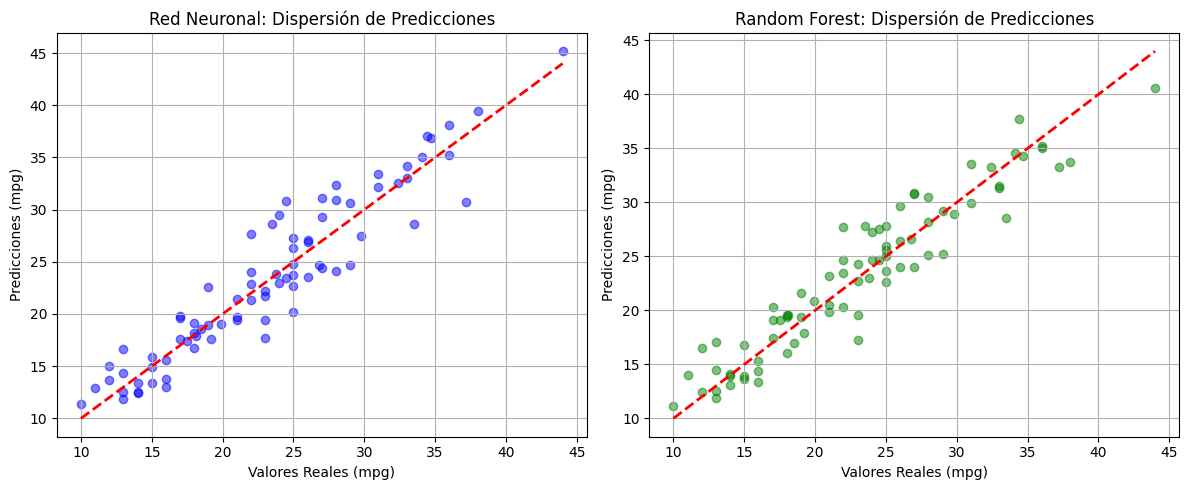

In [271]:
import matplotlib.pyplot as plt

# Gráfica de dispersión
plt.figure(figsize=(12, 5))

# Red Neuronal
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_nn, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales (mpg)')
plt.ylabel('Predicciones (mpg)')
plt.title('Red Neuronal: Dispersión de Predicciones')
plt.grid(True)

# Random Forest
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales (mpg)')
plt.ylabel('Predicciones (mpg)')
plt.title('Random Forest: Dispersión de Predicciones')
plt.grid(True)

plt.tight_layout()
plt.show()

## Gráfica de Residuos

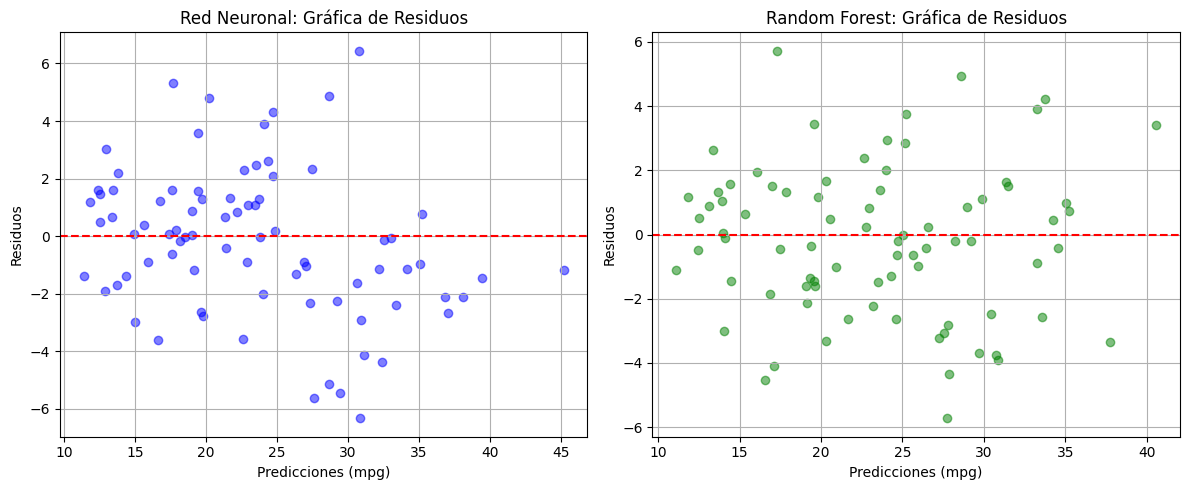

In [272]:
import matplotlib.pyplot as plt

# Residuos
nn_residuals = y_test - y_pred_nn
rf_residuals = y_test - y_pred_rf

plt.figure(figsize=(12, 5))

# Red Neuronal
plt.subplot(1, 2, 1)
plt.scatter(y_pred_nn, nn_residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones (mpg)')
plt.ylabel('Residuos')
plt.title('Red Neuronal: Gráfica de Residuos')
plt.grid(True)

# Random Forest
plt.subplot(1, 2, 2)
plt.scatter(y_pred_rf, rf_residuals, color='green', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones (mpg)')
plt.ylabel('Residuos')
plt.title('Random Forest: Gráfica de Residuos')
plt.grid(True)

plt.tight_layout()
plt.show()